In [1]:
import cmath
from datetime import datetime
import json
import os
import warnings

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import sympy as sp

from qaoa_solver import QAOASolver
from utils import *

warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
def get_setup(experiment):
    return '_'.join(experiment.split('_')[2:])

In [ ]:
experiment_names = [e.removesuffix('_conf.json') for e in os.listdir('experiments') if e.endswith('_conf.json')]
experiment_configs = []
experiment_results = []

for experiment in experiment_names:
    try:
        with open(f'experiments/{experiment}_conf.json', 'r') as f:
            conf = json.load(f)
            conf['experiment'] = experiment
            conf['setup'] = get_setup(experiment)
            experiment_configs.append(conf)
        
        experiment_result_files = os.listdir(f'experiments/results/{experiment}')
        
        for result_file in experiment_result_files:
            result_date = datetime.strptime(result_file.split('_')[-1].split('.json')[0], '%Y%m%d%H%M%S')
            result = pd.read_json(f'experiments/results/{experiment}/{result_file}',lines=True)
            result['experiment'] = experiment
            result['modification_date'] = result_date
            experiment_results.append(result)
    except:
        print(f'Error reading experiment {experiment}')

experiment_configs = pd.DataFrame(experiment_configs)

experiment_results = pd.concat(experiment_results)
experiment_results = experiment_results.rename(columns={'success': 'optimizer_success', 'message': 'optimizer_message'})
experiment_results['num_qubits'] = experiment_results['nx'] + experiment_results['ny']
experiment_results['num_2qub_gates'] = experiment_results['gate_sizes'].apply(lambda d: d['2']*2 + d.get('3',0)*4 + d.get('4',0)*6)
experiment_results['state_populations'] = experiment_results['state'].apply(lambda s: [abs(complex(c))**2 for c in s])
experiment_results['comp_max_population_int'] = experiment_results['state_populations'].apply(lambda s: np.argmax(s))
experiment_results['comp_max_population_bin'] = experiment_results.apply(lambda row: int_to_binary_str(row['comp_max_population_int'], row['nx']+row['ny']), axis=1)
experiment_results['solution'] = experiment_results.apply(lambda row: compute_solution(row['N']), axis=1)
experiment_results['success'] = experiment_results.apply(lambda row: row['comp_max_population_bin'] in row['solution'], axis=1)
experiment_results['fidelity'] = experiment_results.apply(lambda row: compute_fidelity(row['state_populations'], row['solution']), axis=1)

Error reading experiment N39_p3_linear_abs
Error reading experiment N39_p1_standard
Error reading experiment N35_p6_linear_quadratic
Error reading experiment N39_p4_standard
Error reading experiment N39_p4_linear_abs
Error reading experiment N39_p6_linear_abs
Error reading experiment N39_p3_standard
Error reading experiment N39_p6_standard
Error reading experiment N39_p2_linear_abs
Error reading experiment N35_p6_standard
Error reading experiment N39_p1_linear_abs
Error reading experiment N35_p6_linear_abs
Error reading experiment N39_p7_linear_abs
Error reading experiment N35_p5_standard
Error reading experiment N39_p2_standard
Error reading experiment N39_p5_standard
Error reading experiment N35_p7_linear_abs
Error reading experiment N39_p5_linear_abs
Error reading experiment N35_p7_standard
Error reading experiment N39_p7_standard
Error reading experiment N35_p7_linear_quadratic


In [4]:
experiment_results_agg = (
    experiment_results
        .groupby('experiment')
        .agg({
            'num_qubits': 'first',
            'rep': 'count',
            'optimizer_steps': ['mean', 'median', 'std', 'max', 'min'],
            'num_gates': ['mean', 'median', 'std', 'max', 'min'],
            'num_2qub_gates': ['mean', 'median', 'std', 'max', 'min'],
            'cost': ['mean', 'median', 'std'],
            'success': ['mean', 'median', 'std', 'max', 'min'],
            'fidelity': ['mean', 'median', 'std', 'max', 'min']
        })
    )

experiment_results_agg.columns = ['_'.join(map(str, col)) for col in experiment_results_agg.columns.to_flat_index()]
experiment_results_agg = experiment_results_agg.rename(columns={'num_qubits_first': 'num_qubits'})

experiment_results_agg['infidelity_mean'] = 1 - experiment_results_agg['fidelity_mean']
experiment_results_agg['infidelity_median'] = 1 - experiment_results_agg['fidelity_median']
experiment_results_agg['infidelity_min'] = 1 - experiment_results_agg['fidelity_max']
experiment_results_agg['infidelity_max'] = 1 - experiment_results_agg['fidelity_min']

experiments_df = pd.merge(experiment_configs, experiment_results_agg, how='inner', on='experiment')

if (experiments_df['num_gates_std'] != 0).any():
    print('Warning: There are experiments with inconsistent number of gates')

In [5]:
df_details = pd.merge(experiment_configs, experiment_results, how='inner', on='experiment')
df_details = df_details.drop(columns='layers_y')
df_details = df_details.rename(columns={'layers_x': 'layers'})

hist_data = df_details.groupby(['N', 'layers', 'setup'])['comp_max_population_bin'].value_counts().reset_index()

# N = 15

* Required qubits: $n_x = 1,\ n_y = 2$
* Factorization: $15 = 3 \times 5$
* Factor simplification: $3 \rightarrow 1,\ 5 \rightarrow 2$
* Binary factors: $1 \rightarrow 1,\ 2 \rightarrow 10$
* Solution: $\ket{101}$

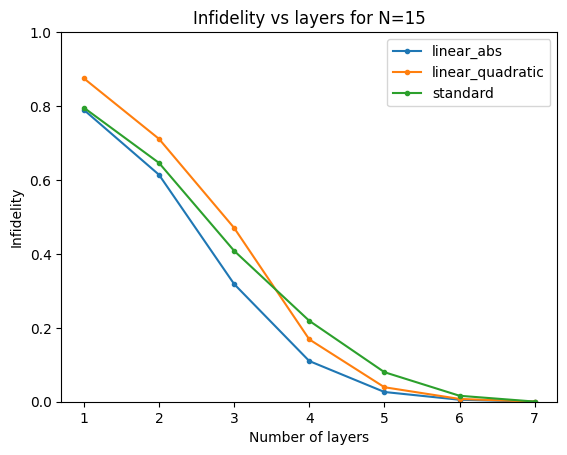

In [6]:
N = 15

df = experiments_df[experiments_df['number'] == N].sort_values(by=['setup', 'layers']).reset_index()
num_qubits = df.loc[0,'num_qubits']

setups = df['setup'].unique().tolist()
layers = df['layers'].unique()

for setup in setups:
    df_s = df[df['setup']==setup].copy()
    plt.plot('layers', 'infidelity_median', data=df_s, marker='.')
    plt.xticks(ticks=layers)

plt.title(f'Infidelity vs layers for N={N}')
plt.xlabel('Number of layers')
plt.ylabel('Infidelity')
plt.ylim(0,1)
plt.legend(setups);

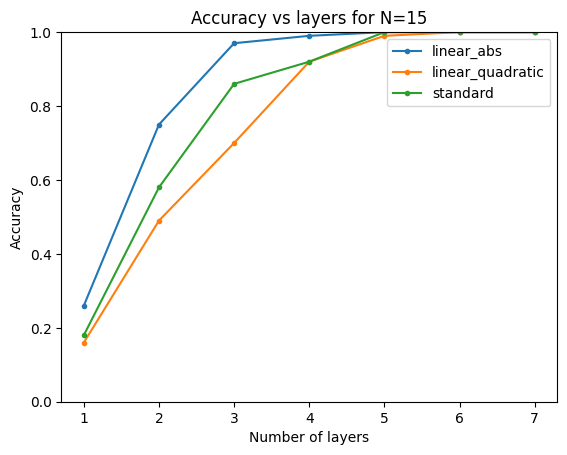

In [7]:
for setup in setups:
    df_s = df[df['setup']==setup].copy()
    plt.plot('layers', 'success_mean', data=df_s, marker='.')
    plt.xticks(ticks=layers)

plt.title(f'Accuracy vs layers for N={N}')
plt.xlabel('Number of layers')
plt.ylabel('Accuracy')
plt.ylim(0,1)
plt.legend(setups);

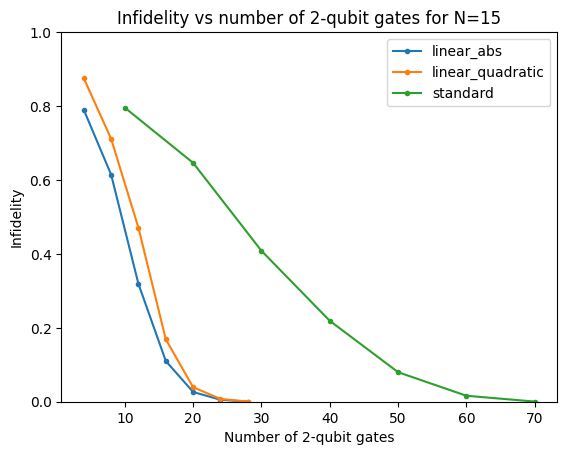

In [8]:
for setup in setups:
    df_s = df[df['setup']==setup]
    plt.plot('num_2qub_gates_max', 'infidelity_median', data=df_s, marker='.')

plt.title(f'Infidelity vs number of 2-qubit gates for N={N}')
plt.xlabel('Number of 2-qubit gates')
plt.ylabel('Infidelity')
plt.ylim(0,1)
plt.legend(setups);

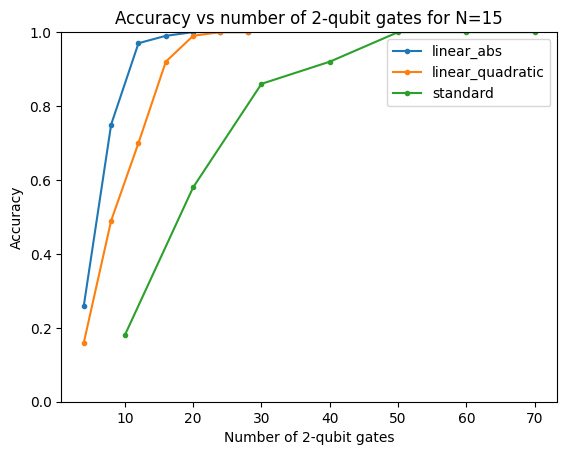

In [9]:
for setup in setups:
    df_s = df[df['setup']==setup]
    plt.plot('num_2qub_gates_max', 'success_mean', data=df_s, marker='.')

plt.title(f'Accuracy vs number of 2-qubit gates for N={N}')
plt.xlabel('Number of 2-qubit gates')
plt.ylabel('Accuracy')
plt.ylim(0,1)
plt.legend(setups);

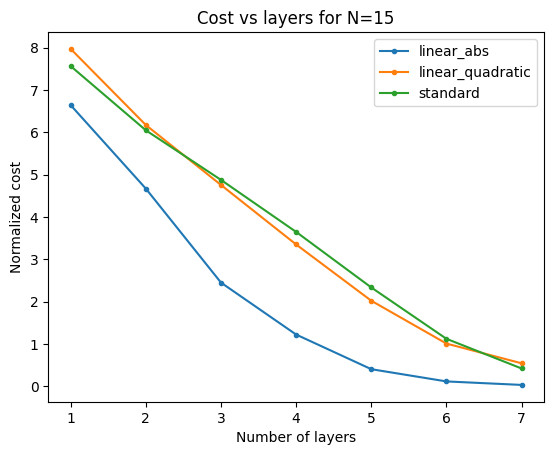

In [10]:
for setup in setups:
    df_s = df[df['setup']==setup].copy()
    if setup != 'linear_abs':
        df_s['cost_mean'] = np.sqrt(df_s['cost_mean'])
    plt.plot('layers', 'cost_mean', data=df_s, marker='.')
    plt.xticks(ticks=layers)

plt.title(f'Cost vs layers for N={N}')
plt.xlabel('Number of layers')
plt.ylabel('Normalized cost')
plt.legend(setups);

Correlation: 0.9940787627280303


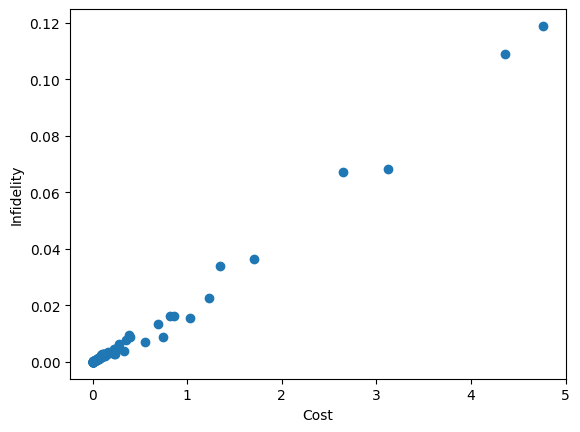

In [11]:
df_det = df_details[(df_details['N']==N) & (df_details['setup']=='linear_quadratic') & (df_details['layers']==7)].copy()
df_det['infidelity'] = 1 - df_det['fidelity']

plt.scatter('cost', 'infidelity', data=df_det);
plt.xlabel('Cost');
plt.ylabel('Infidelity');

print('Correlation:', df_det['infidelity'].corr(df_det['cost']))

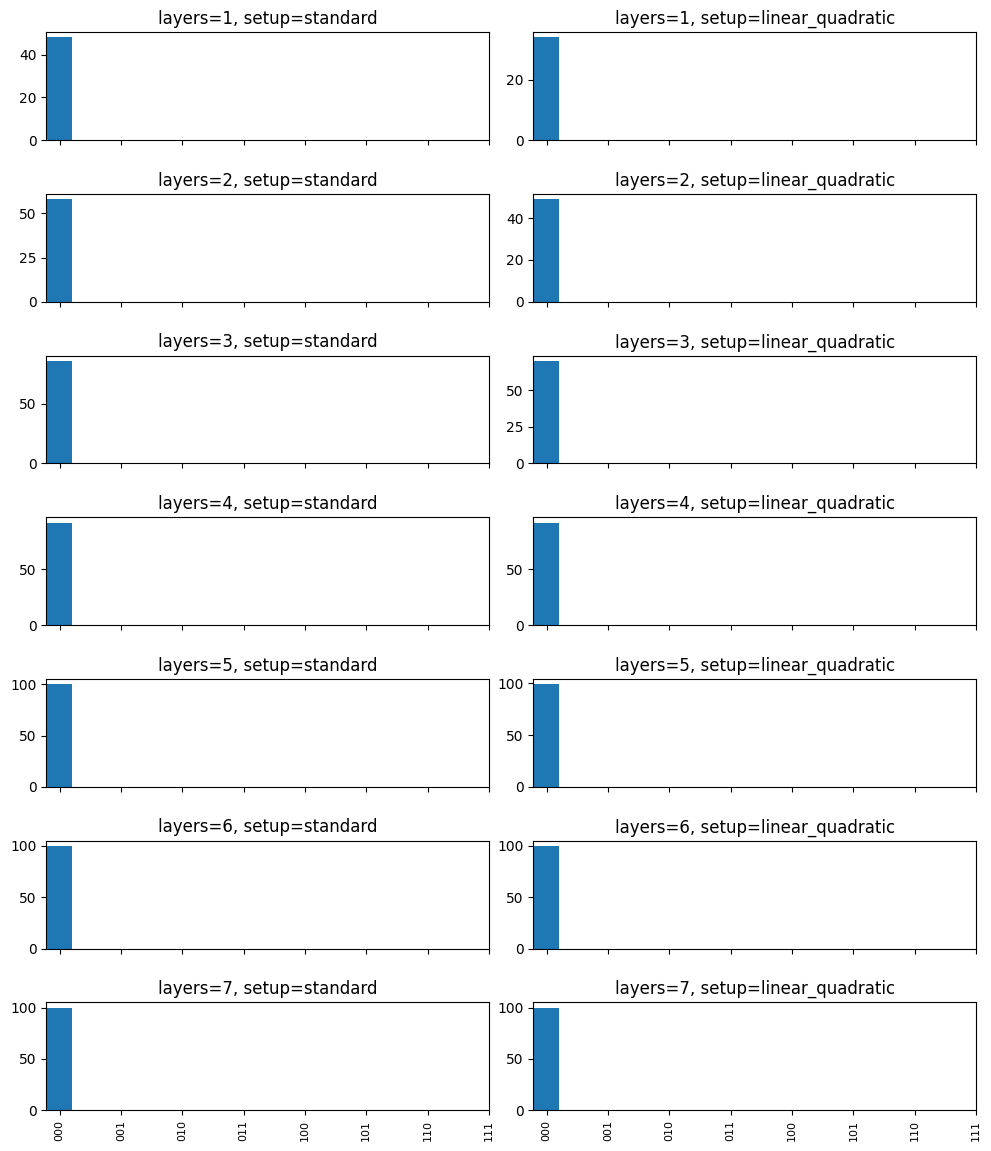

In [12]:
layers = sorted(df['layers'].unique())
x_hist = [int_to_binary_str(n, num_qubits) for n in range(2**num_qubits)]
hist_data_n = hist_data[hist_data['N']==N]

fig, axs = plt.subplots(len(layers), 2, figsize=(12,14), sharex=True)
fig.subplots_adjust(wspace=0.1, hspace=0.5)

for l in layers:
    df_l_default = hist_data_n[(hist_data_n['layers']==l) & (hist_data_n['setup']=='standard')].copy()
    df_l_abs = hist_data_n[(hist_data_n['layers']==l) & (hist_data_n['setup']=='linear_quadratic')].copy()

    axs[l-1][0].bar('state_comp_max', 'count', data=df_l_default, width=0.4)
    axs[l-1][0].set_title(f'layers={l}, setup=standard', fontsize=12)

    axs[l-1][1].bar('state_comp_max', 'count', data=df_l_abs, width=0.4)
    axs[l-1][1].set_title(f'layers={l}, setup=linear_quadratic', fontsize=12)

for ax in axs[-1]:
    ax.set_xticks(range(2**num_qubits))
    ax.set_xticklabels(x_hist, rotation=90, fontsize=8)

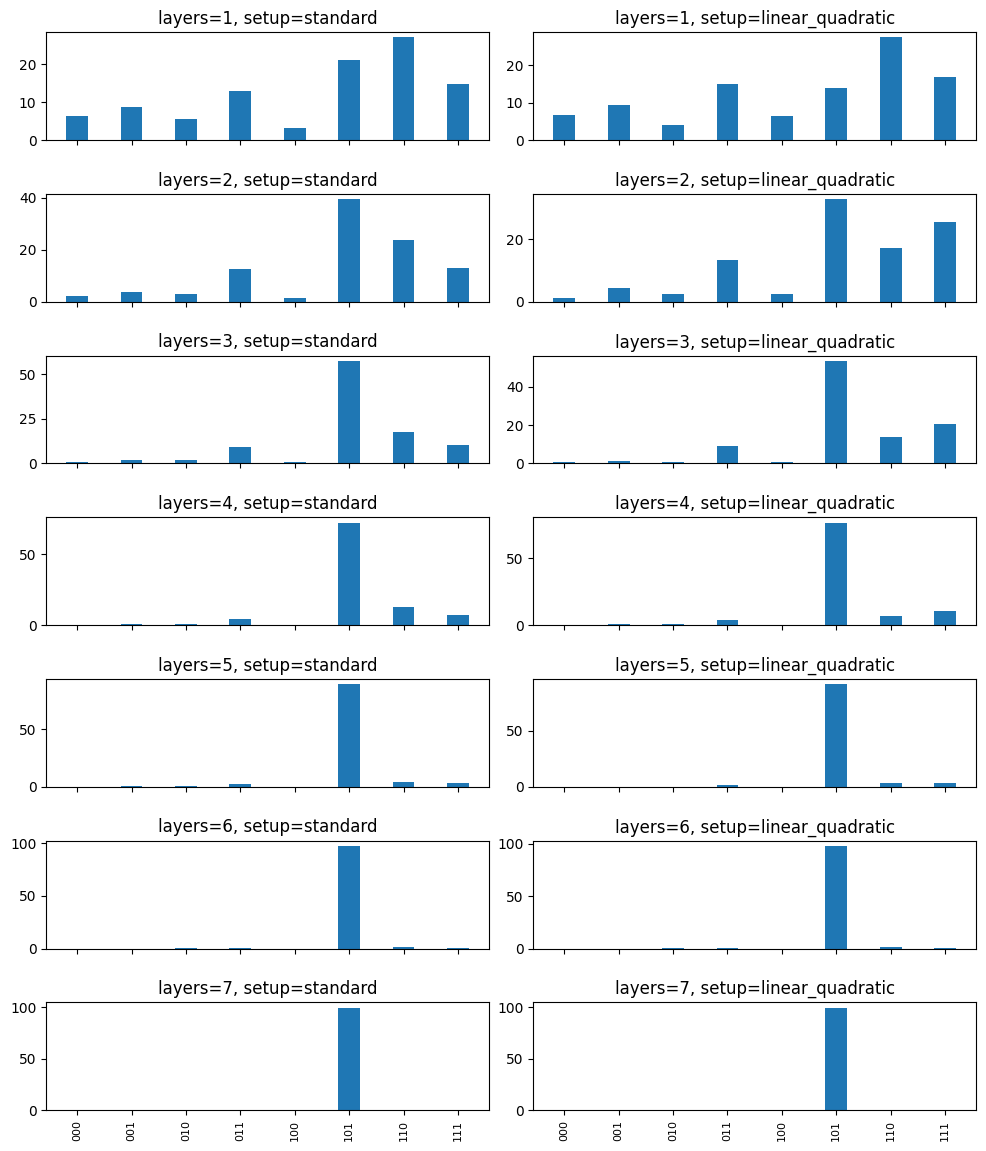

In [14]:
layers = sorted(df['layers'].unique())
df_details_n = df_details[df_details['N']==N].copy().reset_index()

fig, axs = plt.subplots(len(layers), 2, figsize=(12,14), sharex=True)
fig.subplots_adjust(wspace=0.1, hspace=0.5)

for l in layers:
    df_l_default = df_details_n[(df_details_n['layers']==l) & (df_details_n['setup']=='standard')].copy()
    df_l_abs = df_details_n[(df_details_n['layers']==l) & (df_details_n['setup']=='linear_quadratic')].copy()

    populations_default = df_l_default['state_populations'].apply(pd.Series).sum().tolist()
    populations_abs = df_l_abs['state_populations'].apply(pd.Series).sum().tolist()

    axs[l-1][0].bar(range(2**num_qubits), populations_default, width=0.4)
    axs[l-1][0].set_title(f'layers={l}, setup=standard', fontsize=12)
    
    axs[l-1][1].bar(range(2**num_qubits), populations_abs, width=0.4)
    axs[l-1][1].set_title(f'layers={l}, setup=linear_quadratic', fontsize=12)

for ax in axs[-1]:
    ax.set_xticks(range(2**num_qubits))
    ax.set_xticklabels(x_hist, rotation=90, fontsize=8)

# N = 21

* Required qubits: $n_x = 1,\ n_y = 2$
* Factorization: $21 = 3 \times 7$
* Factor simplification: $3 \rightarrow 1,\ 7 \rightarrow 3$
* Binary factors: $1 \rightarrow 1,\ 3 \rightarrow 11$
* Solution: $\ket{111}$

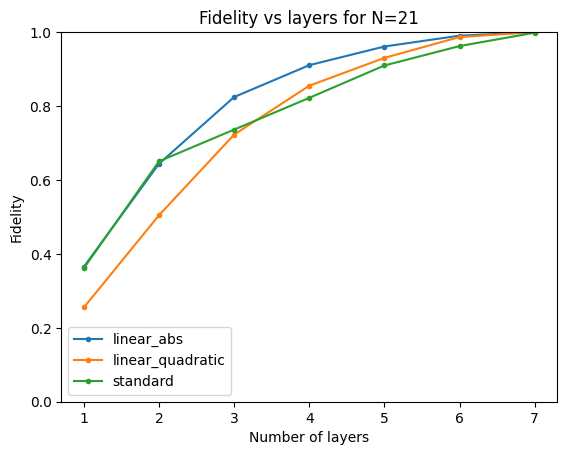

In [16]:
N = 21

df = experiments_df[experiments_df['number'] == N].sort_values(by=['setup', 'layers']).reset_index()
num_qubits = df.loc[0,'num_qubits']

setups = df['setup'].unique().tolist()
layers = df['layers'].unique()

for setup in setups:
    df_s = df[df['setup']==setup].copy()
    plt.plot('layers', 'fidelity_median', data=df_s, marker='.')
    plt.xticks(ticks=layers)

plt.title(f'Fidelity vs layers for N={N}')
plt.xlabel('Number of layers')
plt.ylabel('Fidelity')
plt.ylim(0,1)
plt.legend(setups);

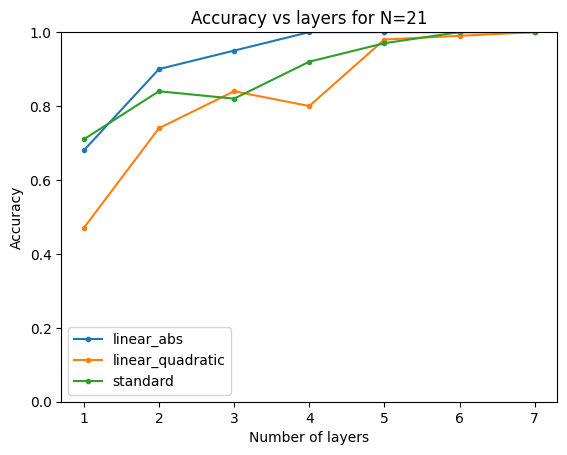

In [17]:
for setup in setups:
    df_s = df[df['setup']==setup].copy()
    plt.plot('layers', 'success_mean', data=df_s, marker='.')
    plt.xticks(ticks=layers)

plt.title(f'Accuracy vs layers for N={N}')
plt.xlabel('Number of layers')
plt.ylabel('Accuracy')
plt.ylim(0,1)
plt.legend(setups);

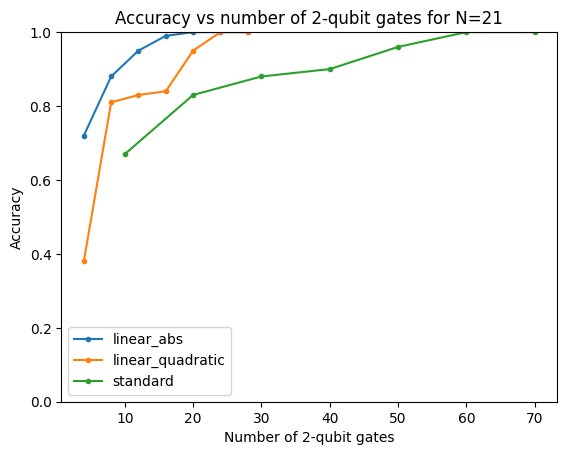

In [ ]:
for setup in setups:
    df_s = df[df['setup']==setup]
    plt.plot('num_2qub_gates_max', 'success_mean', data=df_s, marker='.')

plt.title(f'Accuracy vs number of 2-qubit gates for N={N}')
plt.xlabel('Number of 2-qubit gates')
plt.ylabel('Accuracy')
plt.ylim(0,1)
plt.legend(setups);

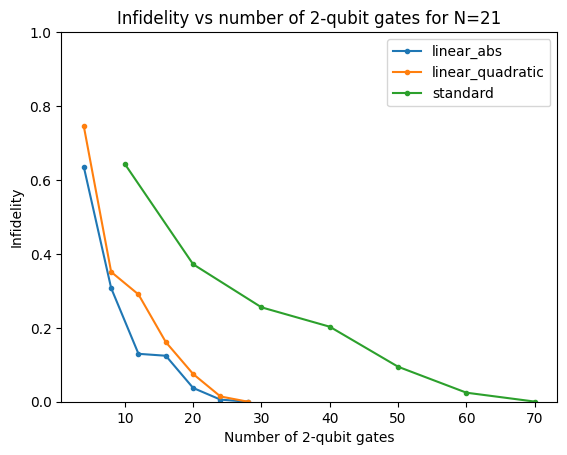

In [ ]:
for setup in setups:
    df_s = df[df['setup']==setup].copy()
    plt.plot('num_2qub_gates_max', 'infidelity_median', data=df_s, marker='.')

plt.title(f'Infidelity vs number of 2-qubit gates for N={N}')
plt.xlabel('Number of 2-qubit gates')
plt.ylabel('Infidelity')
plt.ylim(0,1)
plt.legend(setups);

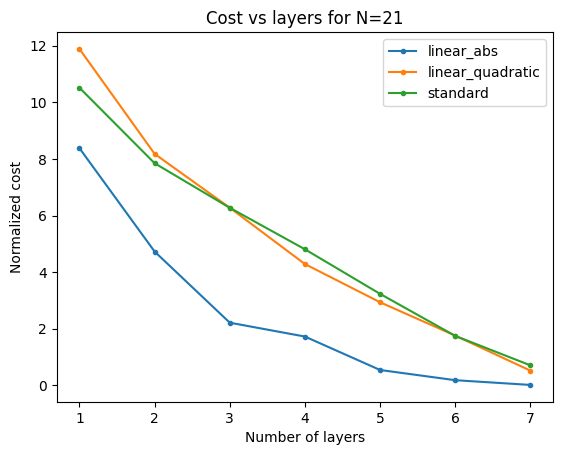

In [ ]:
for setup in setups:
    df_s = df[df['setup']==setup].copy()
    if setup != 'linear_abs':
        df_s['cost_mean'] = np.sqrt(df_s['cost_mean'])
    plt.plot('layers', 'cost_mean', data=df_s, marker='.')
    plt.xticks(ticks=layers)

plt.title(f'Cost vs layers for N={N}')
plt.xlabel('Number of layers')
plt.ylabel('Normalized cost')
plt.legend(setups);

Correlation: 0.9832604444195571


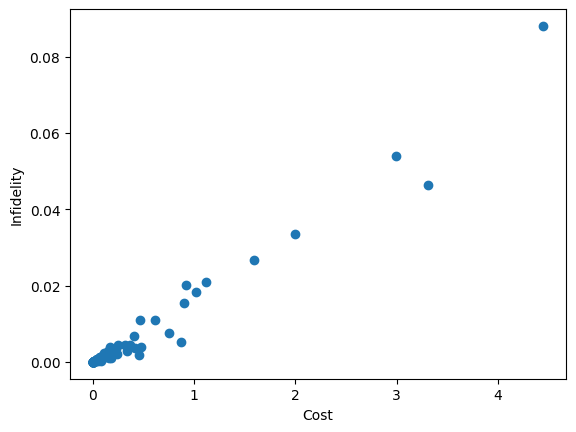

In [ ]:
df_det = df_details[(df_details['N']==N) & (df_details['setup']=='linear_quadratic') & (df_details['layers']==7)].copy()
df_det['infidelity'] = 1 - df_det['fidelity']

plt.scatter('cost', 'infidelity', data=df_det);
plt.xlabel('Cost');
plt.ylabel('Infidelity');

print('Correlation:', df_det['infidelity'].corr(df_det['cost']))

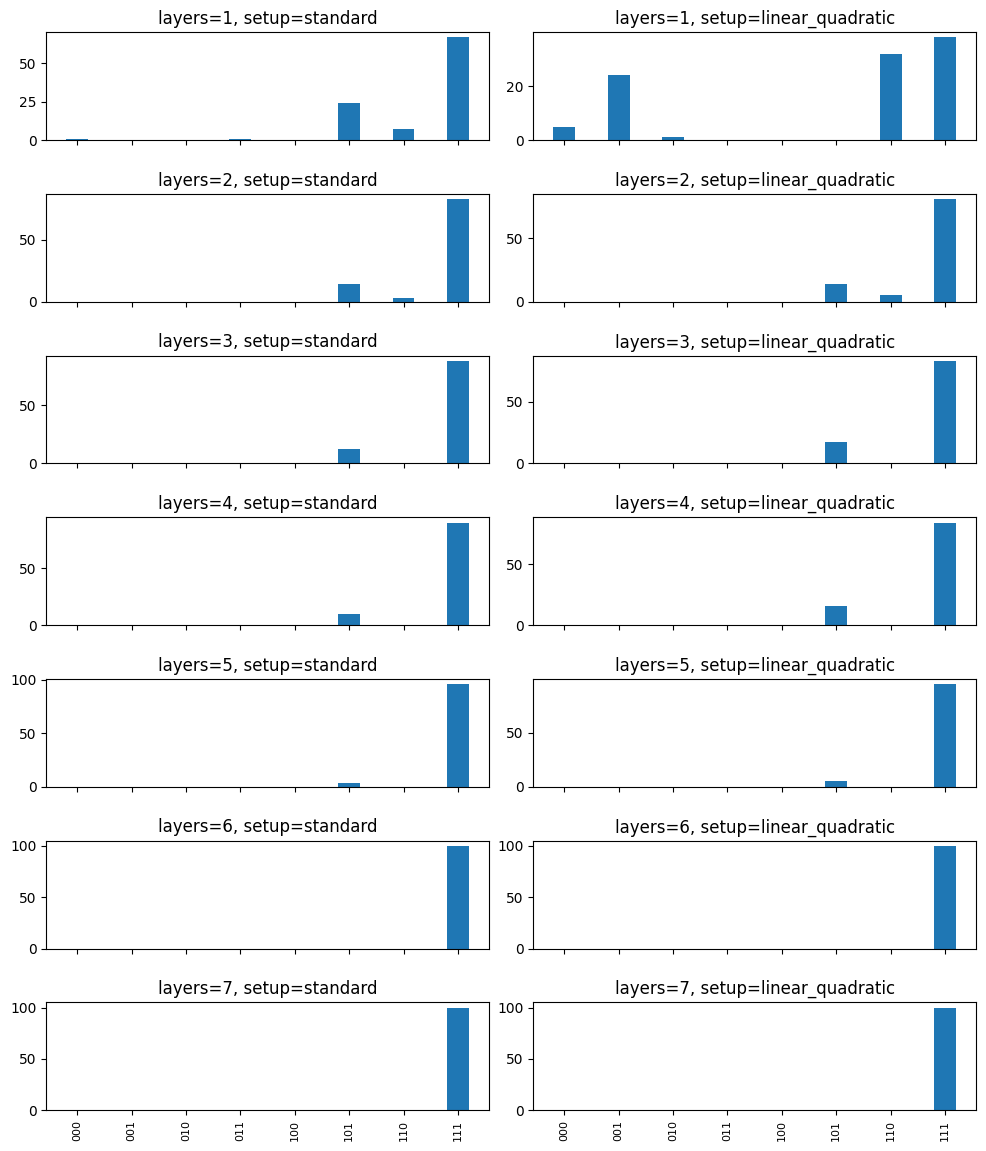

In [ ]:
layers = sorted(df['layers'].unique())
x_hist = [int_to_binary_str(n, num_qubits) for n in range(2**num_qubits)]
hist_data_n = hist_data[hist_data['N']==N]

fig, axs = plt.subplots(len(layers), 2, figsize=(12,14), sharex=True)
fig.subplots_adjust(wspace=0.1, hspace=0.5)

for l in layers:
    df_l_default = hist_data_n[(hist_data_n['layers']==l) & (hist_data_n['setup']=='standard')].copy()
    df_l_abs = hist_data_n[(hist_data_n['layers']==l) & (hist_data_n['setup']=='linear_quadratic')].copy()

    axs[l-1][0].bar('state_comp_max', 'count', data=df_l_default, width=0.4)
    axs[l-1][0].set_title(f'layers={l}, setup=standard', fontsize=12)

    axs[l-1][1].bar('state_comp_max', 'count', data=df_l_abs, width=0.4)
    axs[l-1][1].set_title(f'layers={l}, setup=linear_quadratic', fontsize=12)

for ax in axs[-1]:
    ax.set_xticks(range(2**num_qubits))
    ax.set_xticklabels(x_hist, rotation=90, fontsize=8)

AttributeError: 'int' object has no attribute 'tolist'

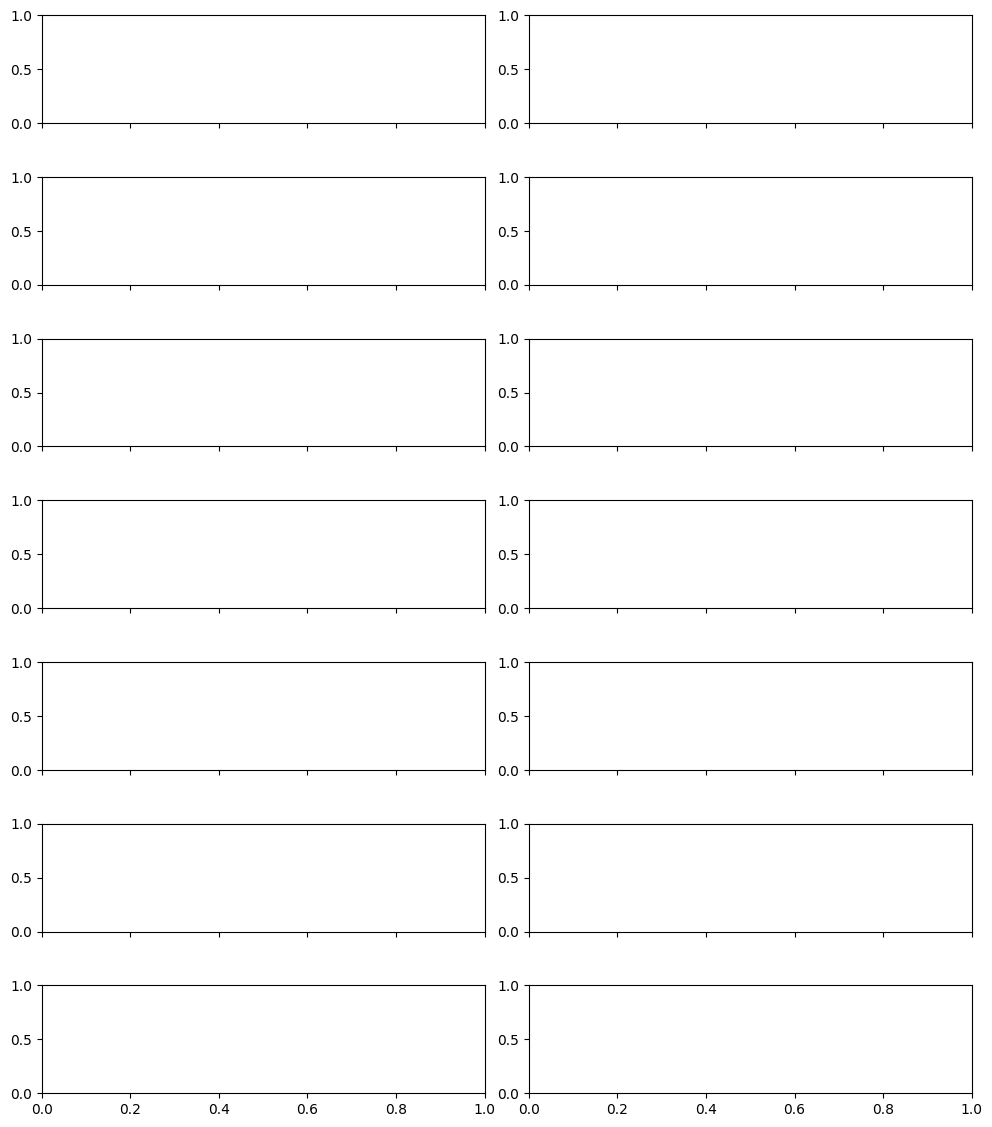

In [ ]:
layers = sorted(df['layers'].unique())
df_details_n = df_details[df_details['N']==N].copy().reset_index()

fig, axs = plt.subplots(len(layers), 2, figsize=(12,14), sharex=True)
fig.subplots_adjust(wspace=0.1, hspace=0.5)

for l in layers:
    df_l_default = df_details_n[(df_details_n['layers']==l) & (df_details_n['setup']=='default')].copy()
    df_l_abs = df_details_n[(df_details_n['layers']==l) & (df_details_n['setup']=='Hp=simp_Hc=abs')].copy()

    populations_default = df_l_default['state_comp_probs'].apply(pd.Series).sum().tolist()
    populations_abs = df_l_abs['state_comp_probs'].apply(pd.Series).sum().tolist()

    axs[l-1][0].bar(range(2**num_qubits), populations_default, width=0.4)
    axs[l-1][1].bar(range(2**num_qubits), populations_abs, width=0.4)
    #, title=f'Populations for N={N}, l={l}, setup=default')
    #plot_quantum_state_probabilities(state_abs, axs[l-1][1], title=f'Populations for N={N}, l={l}, setup=abs')

for ax in axs[-1]:
    ax.set_xticks(range(2**num_qubits))
    ax.set_xticklabels(x_hist, rotation=90, fontsize=8)

# N = 33

* Required qubits: $n_x = 2,\ n_y = 3$
* Factorization: $33 = 3 \times 11$
* Factor simplification: $3 \rightarrow 1,\ 11 \rightarrow 5$
* Binary factors: $1 \rightarrow 1,\ 5 \rightarrow 101$
* Solution: $\ket{10101}$

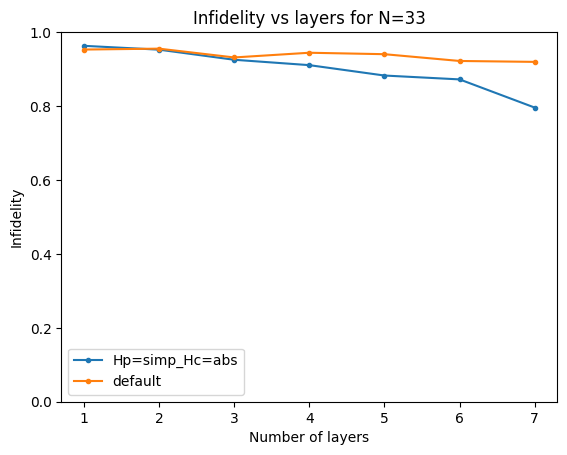

In [ ]:
N = 33

df = experiments_df[experiments_df['number'] == N].sort_values(by=['setup', 'layers']).reset_index()
num_qubits = df.loc[0,'num_qubits']

setups = df['setup'].unique().tolist()
layers = df['layers'].unique()

for setup in setups:
    df_s = df[df['setup']==setup].copy()
    plt.plot('layers', 'infidelity_median', data=df_s, marker='.')
    plt.xticks(ticks=layers)

plt.title(f'Infidelity vs layers for N={N}')
plt.xlabel('Number of layers')
plt.ylabel('Infidelity')
plt.ylim(0,1)
plt.legend(setups);

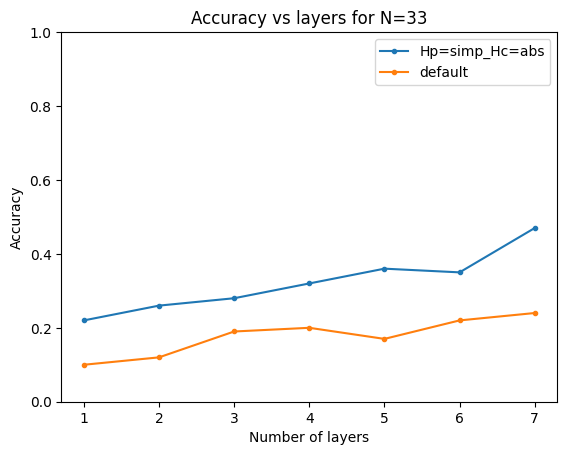

In [ ]:
for setup in setups:
    df_s = df[df['setup']==setup].copy()
    plt.plot('layers', 'success_mean', data=df_s, marker='.')
    plt.xticks(ticks=layers)

plt.title(f'Accuracy vs layers for N={N}')
plt.xlabel('Number of layers')
plt.ylabel('Accuracy')
plt.ylim(0,1)
plt.legend(setups);

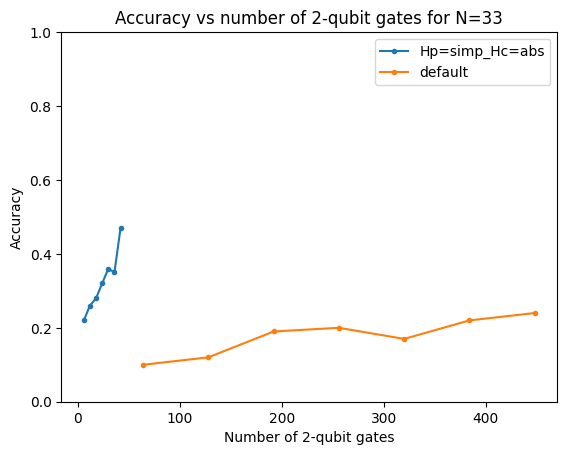

In [ ]:
for setup in setups:
    df_s = df[df['setup']==setup]
    plt.plot('num_2qub_gates_max', 'success_mean', data=df_s, marker='.')

plt.title(f'Accuracy vs number of 2-qubit gates for N={N}')
plt.xlabel('Number of 2-qubit gates')
plt.ylabel('Accuracy')
plt.ylim(0,1)
plt.legend(setups);

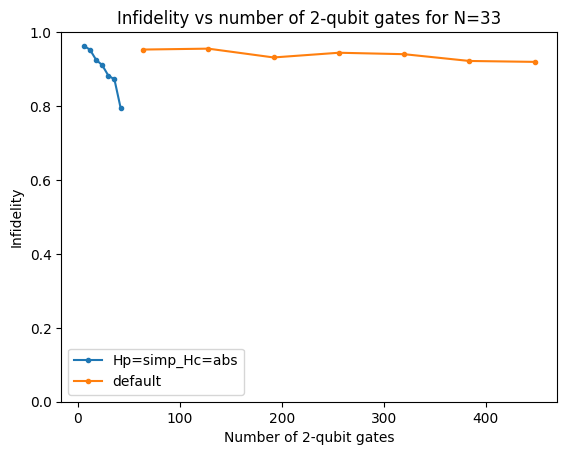

In [ ]:
for setup in setups:
    df_s = df[df['setup']==setup].copy()
    plt.plot('num_2qub_gates_max', 'infidelity_median', data=df_s, marker='.')

plt.title(f'Infidelity vs number of 2-qubit gates for N={N}')
plt.xlabel('Number of 2-qubit gates')
plt.ylabel('Infidelity')
plt.ylim(0,1)
plt.legend(setups);

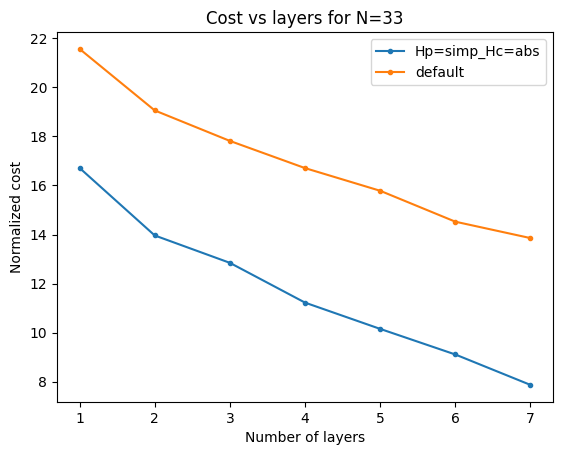

In [ ]:
for setup in setups:
    df_s = df[df['setup']==setup].copy()
    if setup == 'default':
        df_s['cost_mean'] = np.sqrt(df_s['cost_mean'])
    plt.plot('layers', 'cost_mean', data=df_s, marker='.')
    plt.xticks(ticks=layers)

plt.title(f'Cost vs layers for N={N}')
plt.xlabel('Number of layers')
plt.ylabel('Normalized cost')
plt.legend(setups);

Correlation: 0.43435472385508483


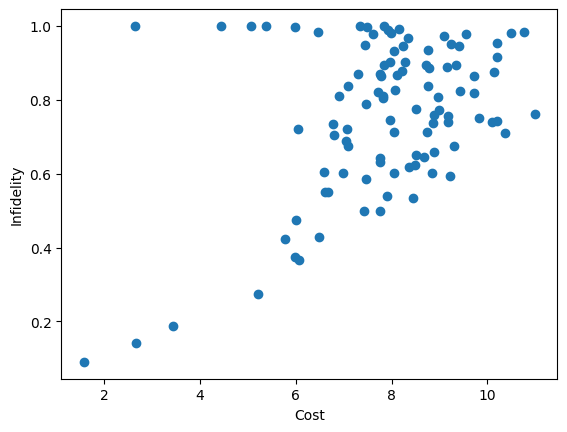

In [ ]:
df_det = df_details[(df_details['N']==N) & (df_details['setup']=='Hp=simp_Hc=abs') & (df_details['layers']==7)].copy()
df_det['infidelity'] = 1 - df_det['fidelity']

plt.scatter('cost', 'infidelity', data=df_det);
plt.xlabel('Cost');
plt.ylabel('Infidelity');

print('Correlation:', df_det['infidelity'].corr(df_det['cost']))

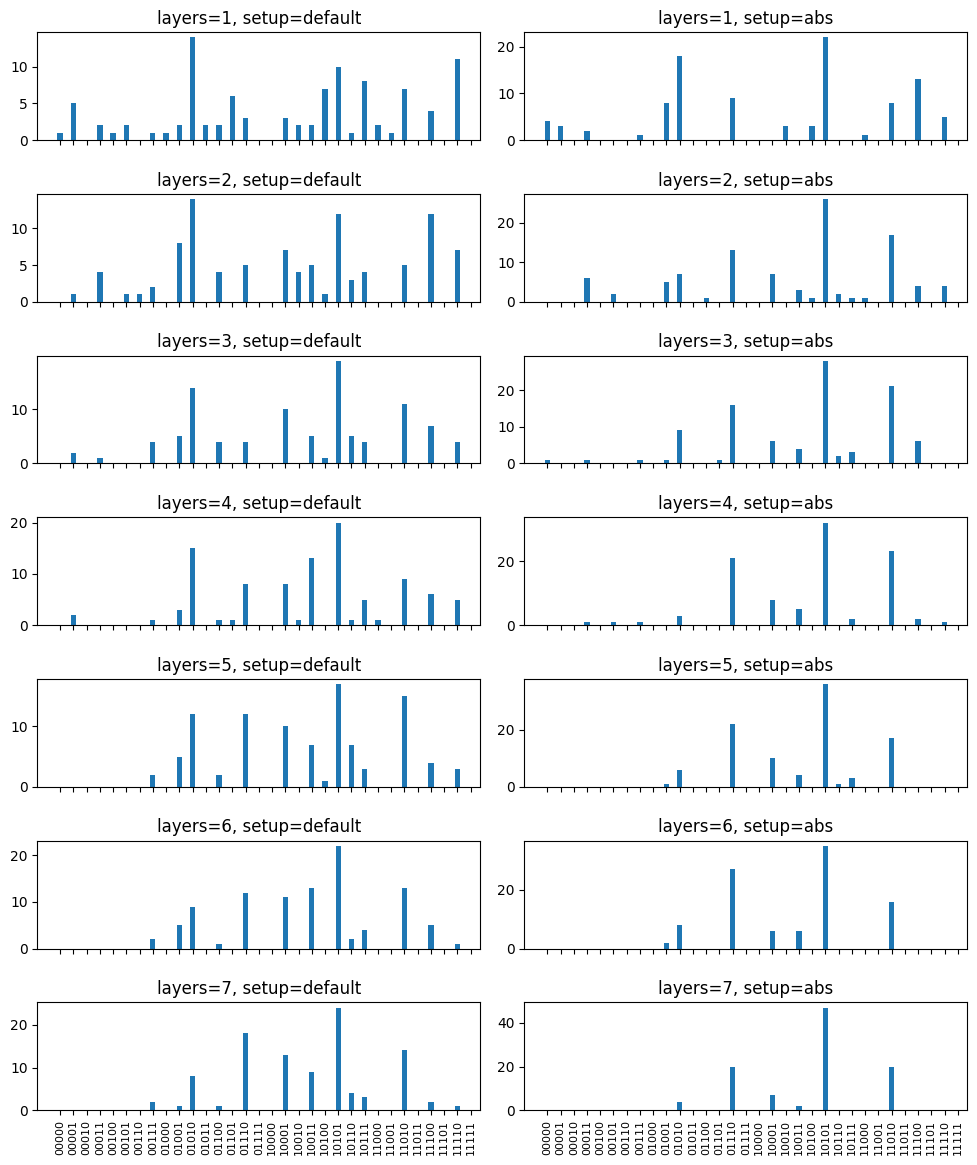

In [ ]:
layers = sorted(df['layers'].unique())
x_hist = [int_to_binary_str(n, num_qubits) for n in range(2**num_qubits)]
hist_data_n = hist_data[hist_data['N']==N]

fig, axs = plt.subplots(len(layers), 2, figsize=(12,14), sharex=True)
fig.subplots_adjust(wspace=0.1, hspace=0.5)

for l in layers:
    df_l_default = hist_data_n[(hist_data_n['layers']==l) & (hist_data_n['setup']=='default')].copy()
    df_l_abs = hist_data_n[(hist_data_n['layers']==l) & (hist_data_n['setup']=='Hp=simp_Hc=abs')].copy()

    axs[l-1][0].bar('state_comp_max', 'count', data=df_l_default, width=0.4)
    axs[l-1][0].set_title(f'layers={l}, setup=default', fontsize=12)

    axs[l-1][1].bar('state_comp_max', 'count', data=df_l_abs, width=0.4)
    axs[l-1][1].set_title(f'layers={l}, setup=abs', fontsize=12)

for ax in axs[-1]:
    ax.set_xticks(range(2**num_qubits))
    ax.set_xticklabels(x_hist, rotation=90, fontsize=8)

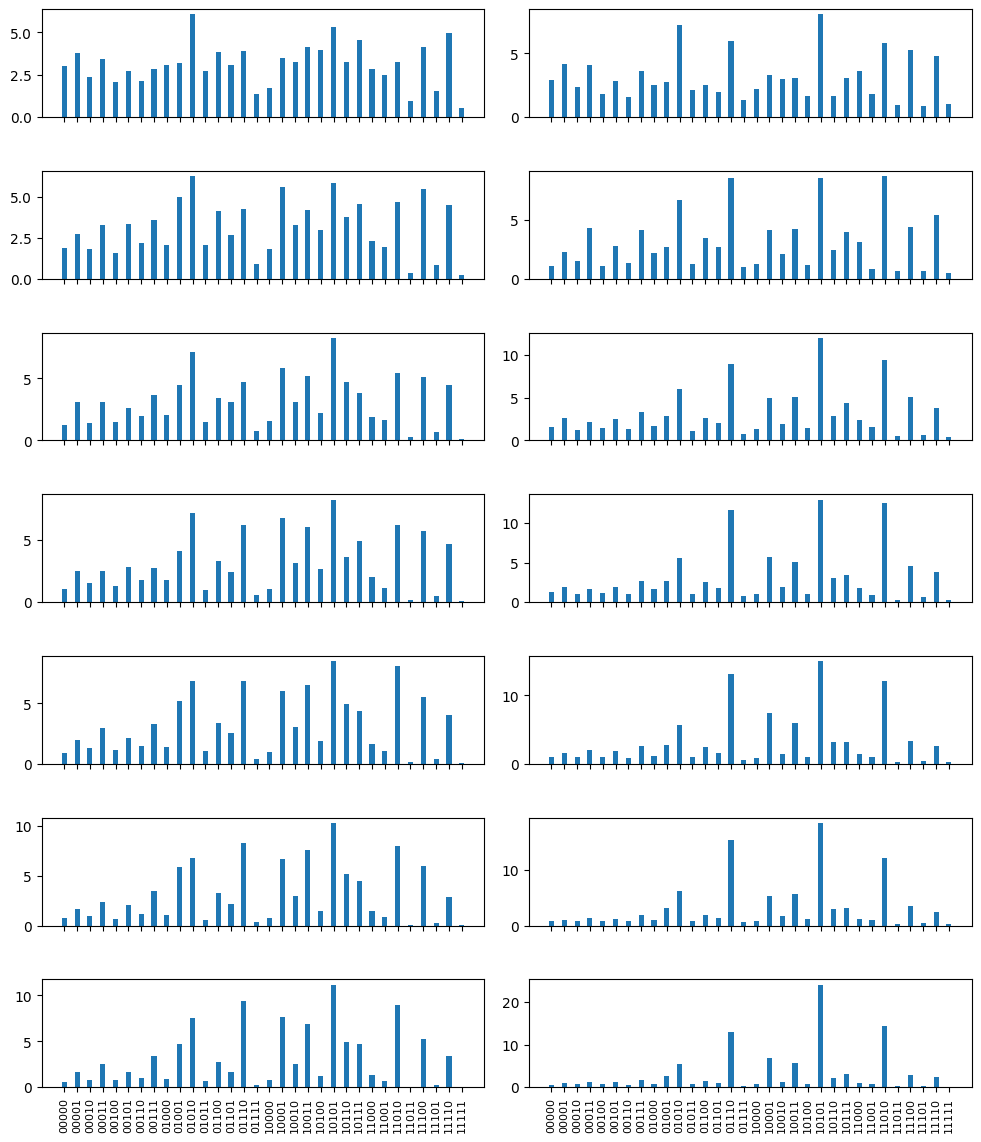

In [ ]:
layers = sorted(df['layers'].unique())
df_details_n = df_details[df_details['N']==N].copy().reset_index()

fig, axs = plt.subplots(len(layers), 2, figsize=(12,14), sharex=True)
fig.subplots_adjust(wspace=0.1, hspace=0.5)

for l in layers:
    df_l_default = df_details_n[(df_details_n['layers']==l) & (df_details_n['setup']=='default')].copy()
    df_l_abs = df_details_n[(df_details_n['layers']==l) & (df_details_n['setup']=='Hp=simp_Hc=abs')].copy()

    populations_default = df_l_default['state_comp_probs'].apply(pd.Series).sum().tolist()
    populations_abs = df_l_abs['state_comp_probs'].apply(pd.Series).sum().tolist()

    axs[l-1][0].bar(range(2**num_qubits), populations_default, width=0.4)
    axs[l-1][1].bar(range(2**num_qubits), populations_abs, width=0.4)
    #, title=f'Populations for N={N}, l={l}, setup=default')
    #plot_quantum_state_probabilities(state_abs, axs[l-1][1], title=f'Populations for N={N}, l={l}, setup=abs')

for ax in axs[-1]:
    ax.set_xticks(range(2**num_qubits))
    ax.set_xticklabels(x_hist, rotation=90, fontsize=8)

# N = 35

* Required qubits: $n_x = 2,\ n_y = 3$
* Factorization: $35 = 5 \times 7$
* Factor simplification: $5 \rightarrow 2,\ 7 \rightarrow 3$
* Binary factors: $2 \rightarrow 10,\ 3 \rightarrow 11$
* Solutions: $\ket{01110}$ and $\ket{11010}$

Degeneracy: solutions 10 and 11 can be exchanged and fit in both $n_x$ and $n_y$ qubits

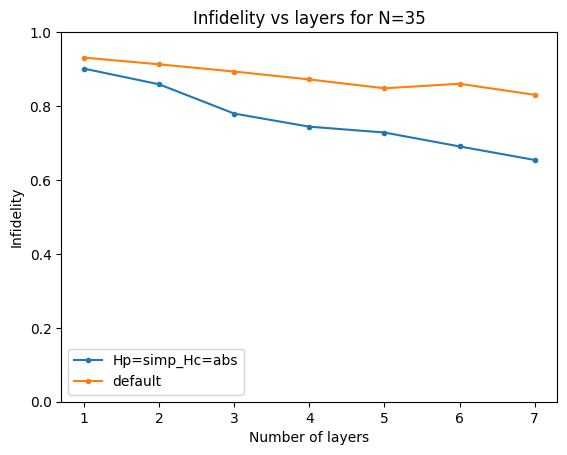

In [ ]:
N = 35

df = experiments_df[experiments_df['number'] == N].sort_values(by=['setup', 'layers']).reset_index()
num_qubits = df.loc[0,'num_qubits']

setups = df['setup'].unique().tolist()
layers = df['layers'].unique()

for setup in setups:
    df_s = df[df['setup']==setup].copy()
    plt.plot('layers', 'infidelity_median', data=df_s, marker='.')
    plt.xticks(ticks=layers)

plt.title(f'Infidelity vs layers for N={N}')
plt.xlabel('Number of layers')
plt.ylabel('Infidelity')
plt.ylim(0,1)
plt.legend(setups);

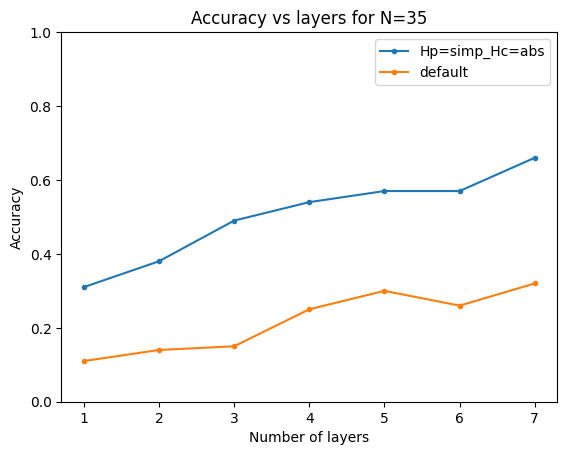

In [ ]:
for setup in setups:
    df_s = df[df['setup']==setup].copy()
    plt.plot('layers', 'success_mean', data=df_s, marker='.')
    plt.xticks(ticks=layers)

plt.title(f'Accuracy vs layers for N={N}')
plt.xlabel('Number of layers')
plt.ylabel('Accuracy')
plt.ylim(0,1)
plt.legend(setups);

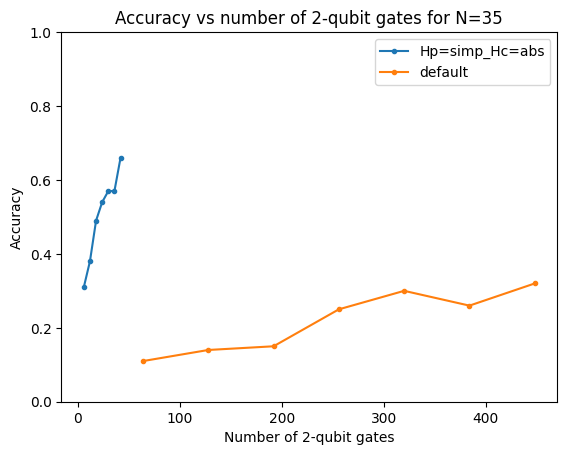

In [ ]:
for setup in setups:
    df_s = df[df['setup']==setup]
    plt.plot('num_2qub_gates_max', 'success_mean', data=df_s, marker='.')

plt.title(f'Accuracy vs number of 2-qubit gates for N={N}')
plt.xlabel('Number of 2-qubit gates')
plt.ylabel('Accuracy')
plt.ylim(0,1)
plt.legend(setups);

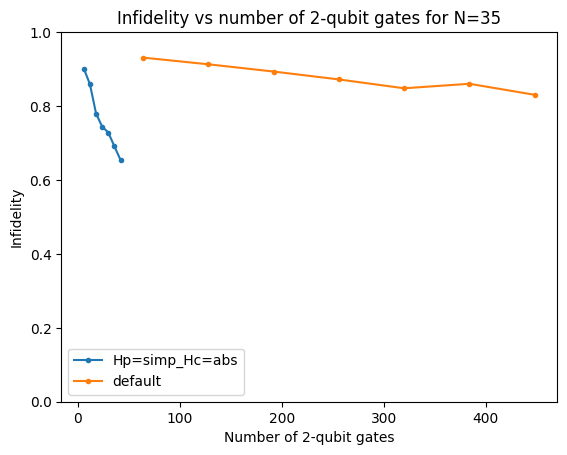

In [ ]:
for setup in setups:
    df_s = df[df['setup']==setup]
    plt.plot('num_2qub_gates_max', 'infidelity_median', data=df_s, marker='.')

plt.title(f'Infidelity vs number of 2-qubit gates for N={N}')
plt.xlabel('Number of 2-qubit gates')
plt.ylabel('Infidelity')
plt.ylim(0,1)
plt.legend(setups);

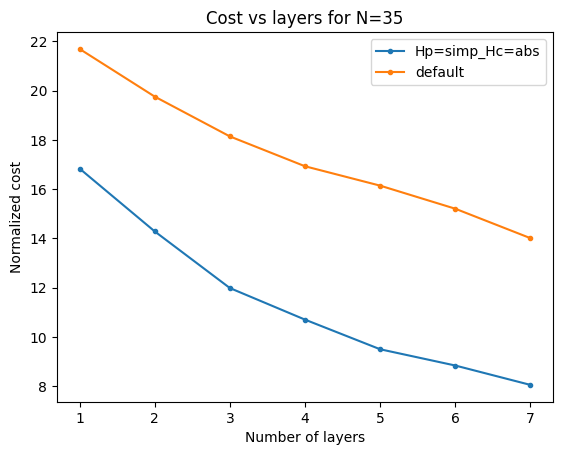

In [ ]:
for setup in setups:
    df_s = df[df['setup']==setup].copy()
    if setup == 'default':
        df_s['cost_mean'] = np.sqrt(df_s['cost_mean'])
    plt.plot('layers', 'cost_mean', data=df_s, marker='.')
    plt.xticks(ticks=layers)

plt.title(f'Cost vs layers for N={N}')
plt.xlabel('Number of layers')
plt.ylabel('Normalized cost')
plt.legend(setups);

Correlation: 0.7432280394765282


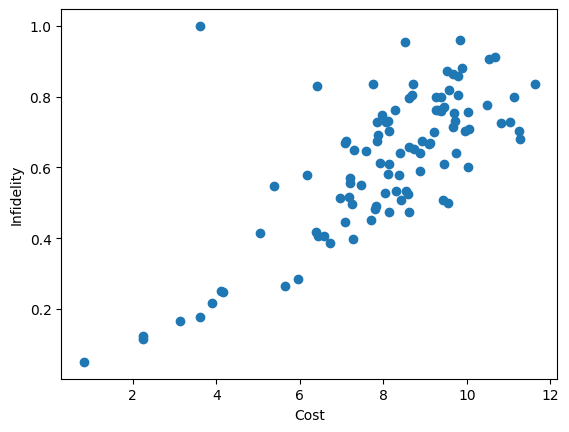

In [ ]:
df_det = df_details[(df_details['N']==N) & (df_details['setup']=='Hp=simp_Hc=abs') & (df_details['layers']==7)].copy()
df_det['infidelity'] = 1 - df_det['fidelity']

plt.scatter('cost', 'infidelity', data=df_det);
plt.xlabel('Cost');
plt.ylabel('Infidelity');

print('Correlation:', df_det['infidelity'].corr(df_det['cost']))

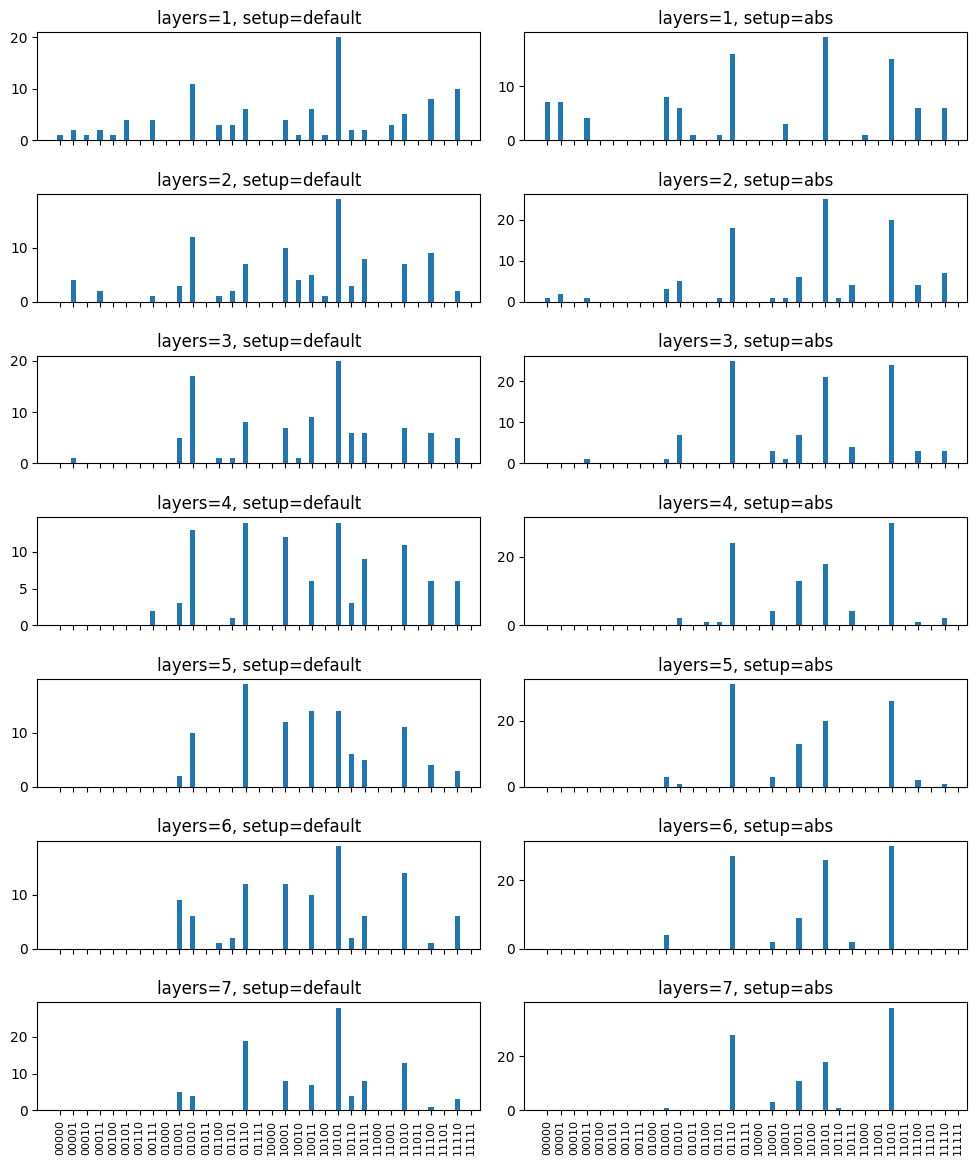

In [ ]:
layers = sorted(df['layers'].unique())
x_hist = [int_to_binary_str(n, num_qubits) for n in range(2**num_qubits)]
hist_data_n = hist_data[hist_data['N']==N]

fig, axs = plt.subplots(len(layers), 2, figsize=(12,14), sharex=True)
fig.subplots_adjust(wspace=0.1, hspace=0.5)

for l in layers:
    df_l_default = hist_data_n[(hist_data_n['layers']==l) & (hist_data_n['setup']=='default')].copy()
    df_l_abs = hist_data_n[(hist_data_n['layers']==l) & (hist_data_n['setup']=='Hp=simp_Hc=abs')].copy()

    axs[l-1][0].bar('state_comp_max', 'count', data=df_l_default, width=0.4)
    axs[l-1][0].set_title(f'layers={l}, setup=default', fontsize=12)

    axs[l-1][1].bar('state_comp_max', 'count', data=df_l_abs, width=0.4)
    axs[l-1][1].set_title(f'layers={l}, setup=abs', fontsize=12)

for ax in axs[-1]:
    ax.set_xticks(range(2**num_qubits))
    ax.set_xticklabels(x_hist, rotation=90, fontsize=8)

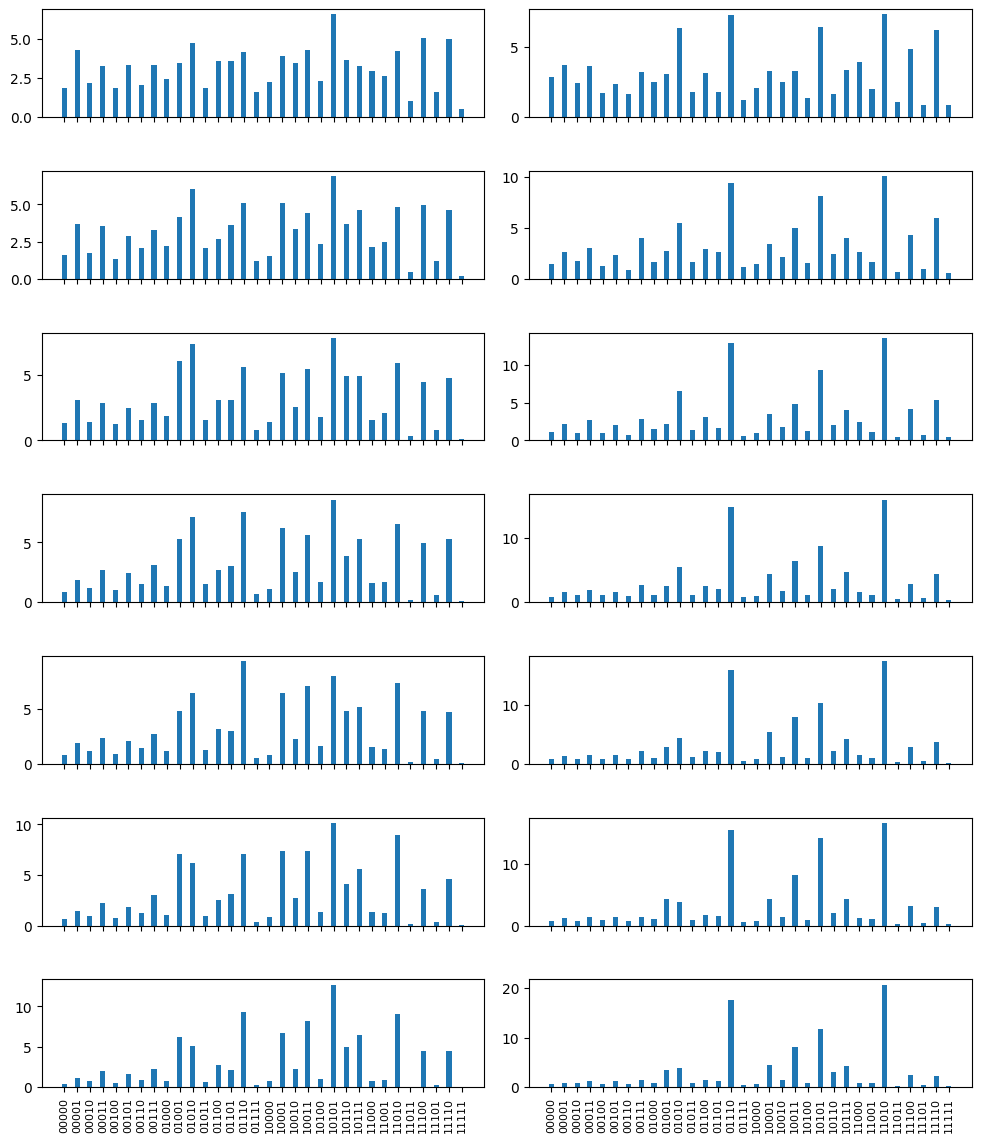

In [ ]:
layers = sorted(df['layers'].unique())
df_details_n = df_details[df_details['N']==N].copy().reset_index()

fig, axs = plt.subplots(len(layers), 2, figsize=(12,14), sharex=True)
fig.subplots_adjust(wspace=0.1, hspace=0.5)

for l in layers:
    df_l_default = df_details_n[(df_details_n['layers']==l) & (df_details_n['setup']=='default')].copy()
    df_l_abs = df_details_n[(df_details_n['layers']==l) & (df_details_n['setup']=='Hp=simp_Hc=abs')].copy()

    populations_default = df_l_default['state_comp_probs'].apply(pd.Series).sum().tolist()
    populations_abs = df_l_abs['state_comp_probs'].apply(pd.Series).sum().tolist()

    axs[l-1][0].bar(range(2**num_qubits), populations_default, width=0.4)
    axs[l-1][1].bar(range(2**num_qubits), populations_abs, width=0.4)
    #, title=f'Populations for N={N}, l={l}, setup=default')
    #plot_quantum_state_probabilities(state_abs, axs[l-1][1], title=f'Populations for N={N}, l={l}, setup=abs')

for ax in axs[-1]:
    ax.set_xticks(range(2**num_qubits))
    ax.set_xticklabels(x_hist, rotation=90, fontsize=8)

# N = 39

* Required qubits: $n_x = 2,\ n_y = 3$
* Factorization: $39 = 3 \times 13$
* Factor simplification: $3 \rightarrow 1,\ 13 \rightarrow 6$
* Binary factors: $3 \rightarrow 01,\ 6 \rightarrow 110$
* Solution: $\ket{10011}$

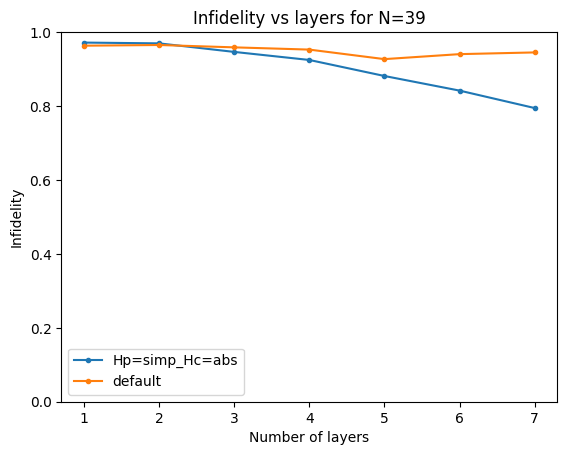

In [ ]:
N = 39

df = experiments_df[experiments_df['number'] == N].sort_values(by=['setup', 'layers']).reset_index()
num_qubits = df.loc[0,'num_qubits']

setups = df['setup'].unique().tolist()
layers = df['layers'].unique()

for setup in setups:
    df_s = df[df['setup']==setup].copy()
    plt.plot('layers', 'infidelity_median', data=df_s, marker='.')
    plt.xticks(ticks=layers)

plt.title(f'Infidelity vs layers for N={N}')
plt.xlabel('Number of layers')
plt.ylabel('Infidelity')
plt.ylim(0,1)
plt.legend(setups);

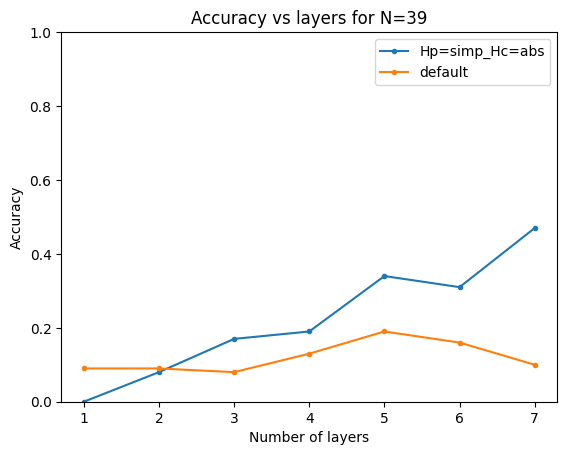

In [ ]:
for setup in setups:
    df_s = df[df['setup']==setup].copy()
    plt.plot('layers', 'success_mean', data=df_s, marker='.')
    plt.xticks(ticks=layers)

plt.title(f'Accuracy vs layers for N={N}')
plt.xlabel('Number of layers')
plt.ylabel('Accuracy')
plt.ylim(0,1)
plt.legend(setups);

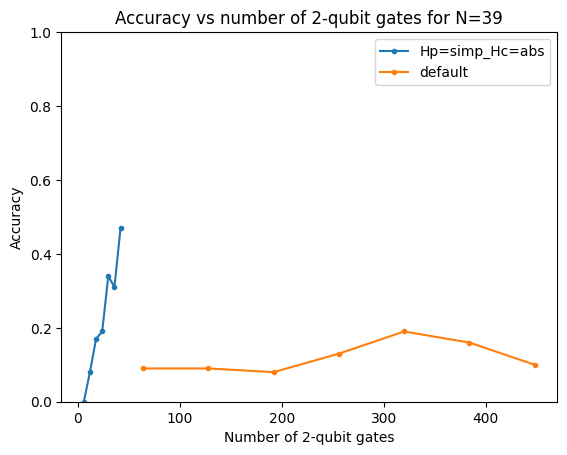

In [ ]:
for setup in setups:
    df_s = df[df['setup']==setup]
    plt.plot('num_2qub_gates_max', 'success_mean', data=df_s, marker='.')

plt.title(f'Accuracy vs number of 2-qubit gates for N={N}')
plt.xlabel('Number of 2-qubit gates')
plt.ylabel('Accuracy')
plt.ylim(0,1)
plt.legend(setups);

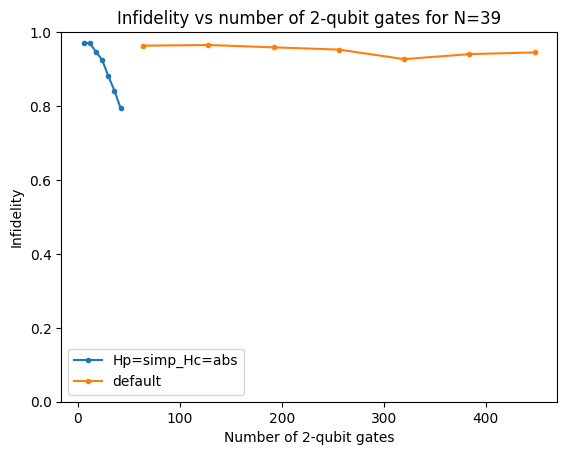

In [ ]:
for setup in setups:
    df_s = df[df['setup']==setup]
    plt.plot('num_2qub_gates_max', 'infidelity_median', data=df_s, marker='.')

plt.title(f'Infidelity vs number of 2-qubit gates for N={N}')
plt.xlabel('Number of 2-qubit gates')
plt.ylabel('Infidelity')
plt.ylim(0,1)
plt.legend(setups);

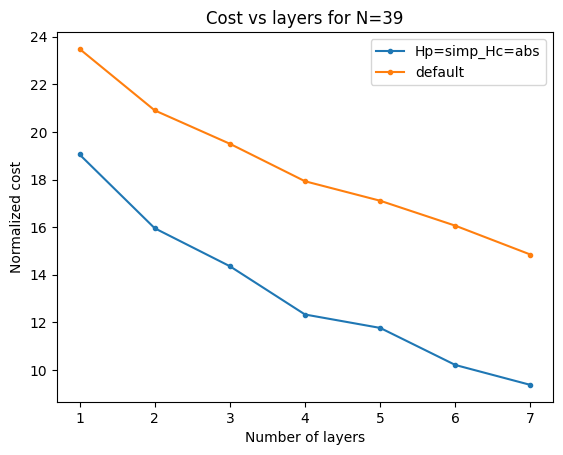

In [ ]:
for setup in setups:
    df_s = df[df['setup']==setup].copy()
    if setup == 'default':
        df_s['cost_mean'] = np.sqrt(df_s['cost_mean'])
    plt.plot('layers', 'cost_mean', data=df_s, marker='.')
    plt.xticks(ticks=layers)

plt.title(f'Cost vs layers for N={N}')
plt.xlabel('Number of layers')
plt.ylabel('Normalized cost')
plt.legend(setups);

Correlation: 0.569116465594675


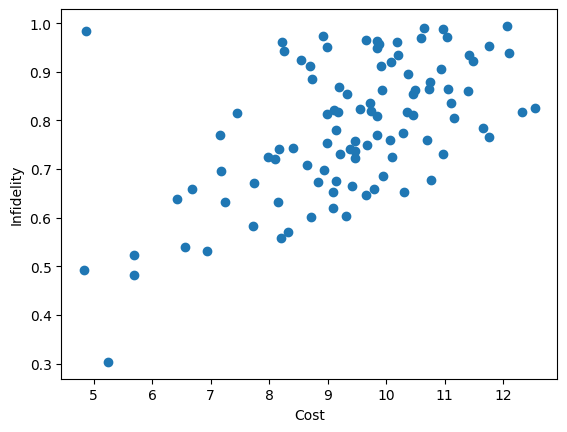

In [ ]:
df_det = df_details[(df_details['N']==N) & (df_details['setup']=='Hp=simp_Hc=abs') & (df_details['layers']==7)].copy()
df_det['infidelity'] = 1 - df_det['fidelity']

plt.scatter('cost', 'infidelity', data=df_det);
plt.xlabel('Cost');
plt.ylabel('Infidelity');

print('Correlation:', df_det['infidelity'].corr(df_det['cost']))

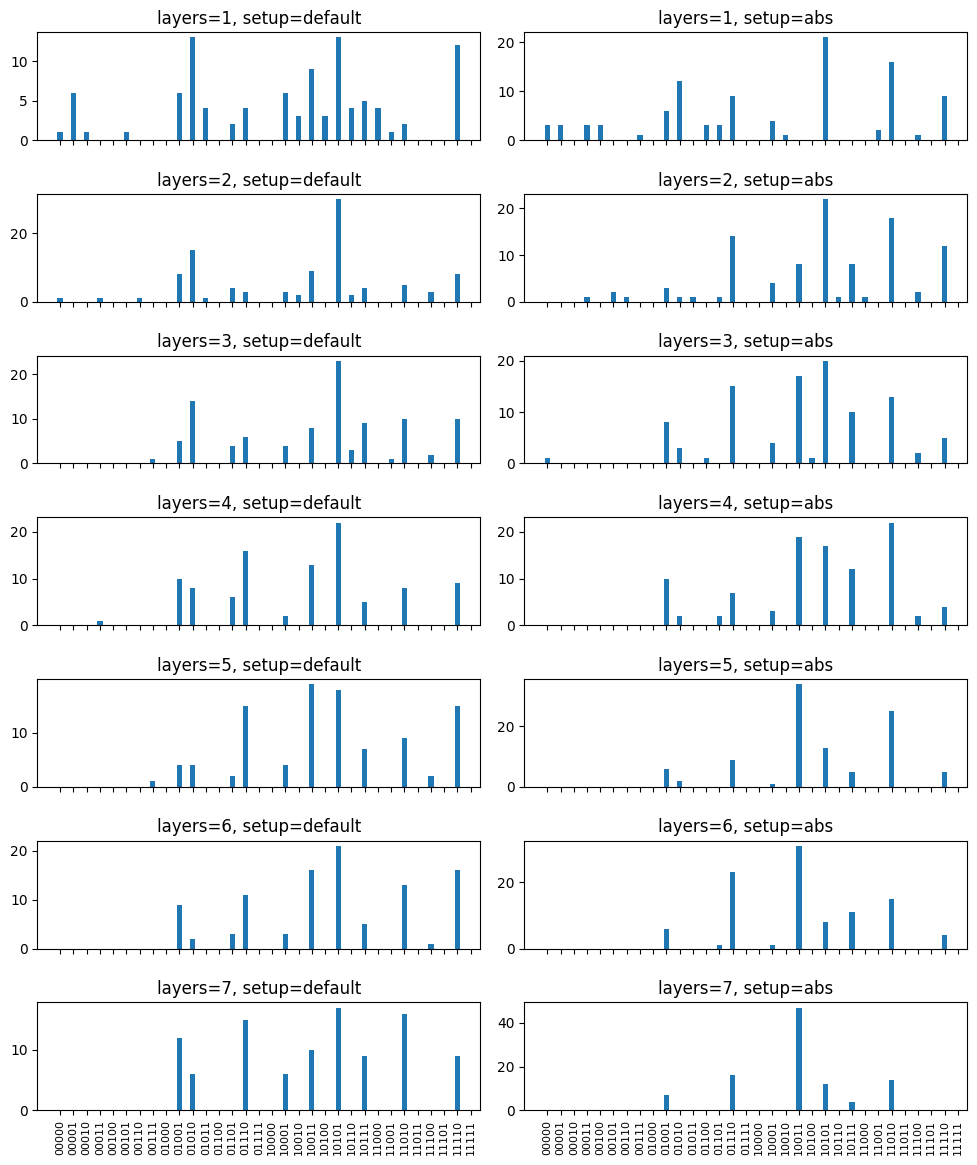

In [ ]:
layers = sorted(df['layers'].unique())
x_hist = [int_to_binary_str(n, num_qubits) for n in range(2**num_qubits)]
hist_data_n = hist_data[hist_data['N']==N]

fig, axs = plt.subplots(len(layers), 2, figsize=(12,14), sharex=True)
fig.subplots_adjust(wspace=0.1, hspace=0.5)

for l in layers:
    df_l_default = hist_data_n[(hist_data_n['layers']==l) & (hist_data_n['setup']=='default')].copy()
    df_l_abs = hist_data_n[(hist_data_n['layers']==l) & (hist_data_n['setup']=='Hp=simp_Hc=abs')].copy()

    axs[l-1][0].bar('state_comp_max', 'count', data=df_l_default, width=0.4)
    axs[l-1][0].set_title(f'layers={l}, setup=default', fontsize=12)

    axs[l-1][1].bar('state_comp_max', 'count', data=df_l_abs, width=0.4)
    axs[l-1][1].set_title(f'layers={l}, setup=abs', fontsize=12)

for ax in axs[-1]:
    ax.set_xticks(range(2**num_qubits))
    ax.set_xticklabels(x_hist, rotation=90, fontsize=8)

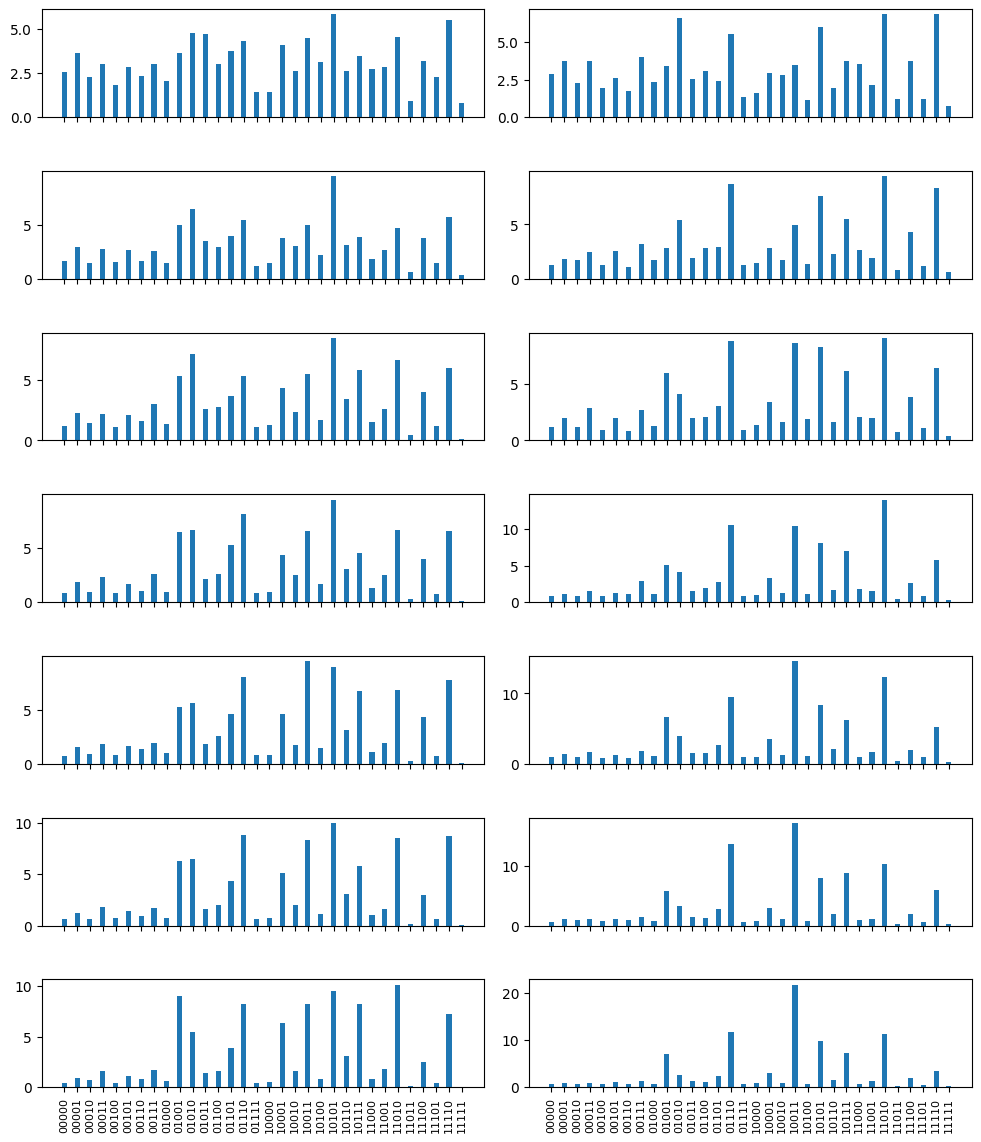

In [ ]:
layers = sorted(df['layers'].unique())
df_details_n = df_details[df_details['N']==N].copy().reset_index()

fig, axs = plt.subplots(len(layers), 2, figsize=(12,14), sharex=True)
fig.subplots_adjust(wspace=0.1, hspace=0.5)

for l in layers:
    df_l_default = df_details_n[(df_details_n['layers']==l) & (df_details_n['setup']=='default')].copy()
    df_l_abs = df_details_n[(df_details_n['layers']==l) & (df_details_n['setup']=='Hp=simp_Hc=abs')].copy()

    populations_default = df_l_default['state_comp_probs'].apply(pd.Series).sum().tolist()
    populations_abs = df_l_abs['state_comp_probs'].apply(pd.Series).sum().tolist()

    axs[l-1][0].bar(range(2**num_qubits), populations_default, width=0.4)
    axs[l-1][1].bar(range(2**num_qubits), populations_abs, width=0.4)
    #, title=f'Populations for N={N}, l={l}, setup=default')
    #plot_quantum_state_probabilities(state_abs, axs[l-1][1], title=f'Populations for N={N}, l={l}, setup=abs')

for ax in axs[-1]:
    ax.set_xticks(range(2**num_qubits))
    ax.set_xticklabels(x_hist, rotation=90, fontsize=8)